# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [38]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data


ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

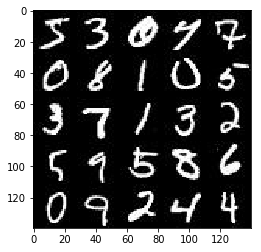

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

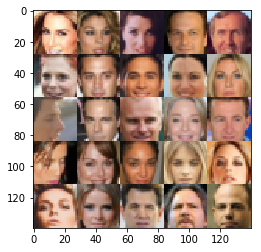

In [47]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [39]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape = [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name = 'input_z')
    lr = tf.placeholder(tf.float32, None, name='lr')
    return (input_real, input_z, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [40]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #Layer1 input -> 28x28x3
        #Layer1 output -> 14*14*64
        #no batch norm in first layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha*x1, x1)
        
        #Layer2 input -> 14*14*64
        #Layer2 output -> 7*7*128
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        
        #Layer3 input -> 7*7*128
        #Layer3 output -> 4*4*256
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        
        # fully connected ouptut layer
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return logits, out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [41]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha*x3, x3)
        
       
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [42]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha=0.2
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    a_logits_real, d_model_real = discriminator(input_real, alpha=alpha)
    a_logits_generated, d_model_generated = discriminator(g_model, alpha=alpha, reuse=True)
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_logits_generated,
                                                                    labels=tf.ones_like(d_model_generated)))
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                        logits=a_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_generated = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                        logits=a_logits_generated, labels=tf.zeros_like(d_model_generated)))
    
    return d_loss_generated+d_loss_real, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [43]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [44]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [45]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height= data_shape[2]
    image_channels = data_shape[3]
       
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, d_generated_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    step=0
    print_every = 20
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step = step + 1
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                batch_images = batch_images*2
                
                _ = sess.run(d_train_opt, feed_dict={input_real:batch_images, input_z:batch_z, lr:learning_rate})
                _ = sess.run(d_generated_opt, feed_dict={input_real:batch_images, input_z:batch_z, lr:learning_rate})                
                _ = sess.run(d_generated_opt, feed_dict={input_real:batch_images, input_z:batch_z, lr:learning_rate})
                
                if step%print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z })
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if step%show_every ==0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2461... Generator Loss: 1.8127
Epoch 1/2... Discriminator Loss: 3.7061... Generator Loss: 0.1112
Epoch 1/2... Discriminator Loss: 2.5299... Generator Loss: 0.1384
Epoch 1/2... Discriminator Loss: 1.9261... Generator Loss: 0.3402
Epoch 1/2... Discriminator Loss: 1.7656... Generator Loss: 0.3967


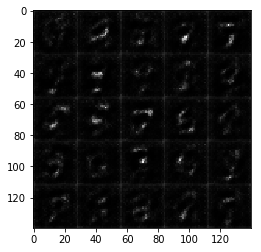

Epoch 1/2... Discriminator Loss: 1.6829... Generator Loss: 0.5868
Epoch 1/2... Discriminator Loss: 1.8974... Generator Loss: 0.2709
Epoch 1/2... Discriminator Loss: 1.9195... Generator Loss: 0.2412
Epoch 1/2... Discriminator Loss: 1.6832... Generator Loss: 0.3691
Epoch 1/2... Discriminator Loss: 1.6802... Generator Loss: 0.3387


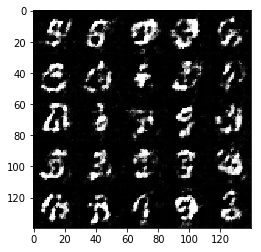

Epoch 1/2... Discriminator Loss: 1.5000... Generator Loss: 0.4010
Epoch 1/2... Discriminator Loss: 1.4489... Generator Loss: 0.5363
Epoch 1/2... Discriminator Loss: 1.1643... Generator Loss: 0.5977
Epoch 1/2... Discriminator Loss: 1.6636... Generator Loss: 0.2975
Epoch 1/2... Discriminator Loss: 1.8073... Generator Loss: 0.3259


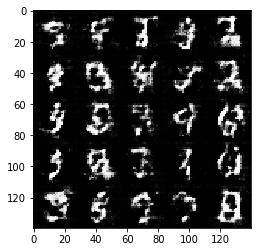

Epoch 1/2... Discriminator Loss: 1.4288... Generator Loss: 0.5944
Epoch 1/2... Discriminator Loss: 1.7857... Generator Loss: 0.3203
Epoch 1/2... Discriminator Loss: 2.1491... Generator Loss: 0.1752
Epoch 1/2... Discriminator Loss: 1.7790... Generator Loss: 0.2844
Epoch 1/2... Discriminator Loss: 1.9201... Generator Loss: 0.2384


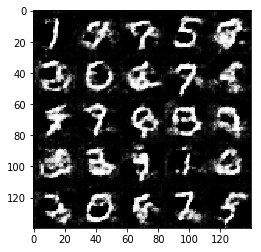

Epoch 1/2... Discriminator Loss: 1.5265... Generator Loss: 0.3595
Epoch 1/2... Discriminator Loss: 1.6264... Generator Loss: 0.3386
Epoch 1/2... Discriminator Loss: 1.6536... Generator Loss: 0.5602
Epoch 1/2... Discriminator Loss: 1.5316... Generator Loss: 0.6986
Epoch 1/2... Discriminator Loss: 1.5631... Generator Loss: 0.6971


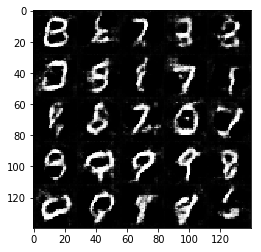

Epoch 1/2... Discriminator Loss: 1.5061... Generator Loss: 0.4360
Epoch 1/2... Discriminator Loss: 1.3663... Generator Loss: 0.5840
Epoch 1/2... Discriminator Loss: 1.4176... Generator Loss: 0.7069
Epoch 1/2... Discriminator Loss: 1.7597... Generator Loss: 0.3538
Epoch 1/2... Discriminator Loss: 2.0790... Generator Loss: 0.2240


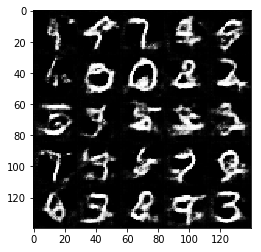

Epoch 1/2... Discriminator Loss: 1.4218... Generator Loss: 0.4445
Epoch 1/2... Discriminator Loss: 1.6089... Generator Loss: 0.8355
Epoch 1/2... Discriminator Loss: 1.2813... Generator Loss: 0.7036
Epoch 1/2... Discriminator Loss: 1.4175... Generator Loss: 0.4334
Epoch 1/2... Discriminator Loss: 1.1970... Generator Loss: 0.6223


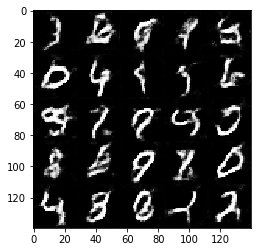

Epoch 1/2... Discriminator Loss: 1.6419... Generator Loss: 0.3599
Epoch 1/2... Discriminator Loss: 1.5550... Generator Loss: 0.4236
Epoch 1/2... Discriminator Loss: 1.0769... Generator Loss: 0.8754
Epoch 1/2... Discriminator Loss: 1.4382... Generator Loss: 0.5310
Epoch 1/2... Discriminator Loss: 2.0734... Generator Loss: 0.1644


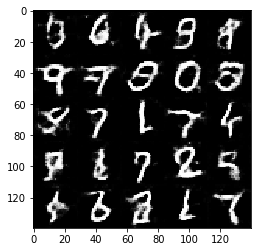

Epoch 1/2... Discriminator Loss: 1.5756... Generator Loss: 0.4655
Epoch 1/2... Discriminator Loss: 1.4512... Generator Loss: 0.4568
Epoch 1/2... Discriminator Loss: 1.7152... Generator Loss: 0.3739
Epoch 1/2... Discriminator Loss: 1.7080... Generator Loss: 0.3033
Epoch 1/2... Discriminator Loss: 1.4445... Generator Loss: 0.3841


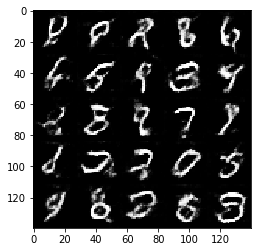

Epoch 1/2... Discriminator Loss: 1.2171... Generator Loss: 0.6669
Epoch 1/2... Discriminator Loss: 1.2981... Generator Loss: 0.5838
Epoch 1/2... Discriminator Loss: 1.4191... Generator Loss: 0.6273
Epoch 1/2... Discriminator Loss: 1.4735... Generator Loss: 0.8865
Epoch 1/2... Discriminator Loss: 1.4646... Generator Loss: 0.3875


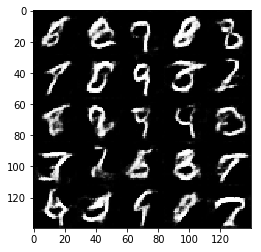

Epoch 1/2... Discriminator Loss: 1.2720... Generator Loss: 0.5533
Epoch 1/2... Discriminator Loss: 1.7886... Generator Loss: 0.2530
Epoch 1/2... Discriminator Loss: 1.5550... Generator Loss: 0.3509
Epoch 1/2... Discriminator Loss: 1.8820... Generator Loss: 0.2231
Epoch 1/2... Discriminator Loss: 1.5134... Generator Loss: 0.4324


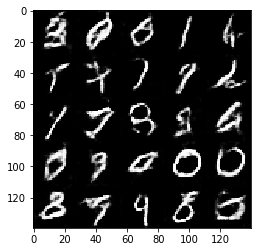

Epoch 1/2... Discriminator Loss: 1.4566... Generator Loss: 0.4479
Epoch 1/2... Discriminator Loss: 1.7685... Generator Loss: 0.2787
Epoch 1/2... Discriminator Loss: 1.3538... Generator Loss: 0.4852
Epoch 1/2... Discriminator Loss: 1.2149... Generator Loss: 0.7985
Epoch 1/2... Discriminator Loss: 1.4554... Generator Loss: 0.4026


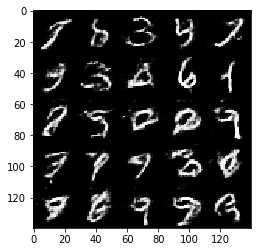

Epoch 1/2... Discriminator Loss: 1.6529... Generator Loss: 0.3386
Epoch 1/2... Discriminator Loss: 1.1610... Generator Loss: 0.7977
Epoch 1/2... Discriminator Loss: 1.8536... Generator Loss: 0.2588
Epoch 1/2... Discriminator Loss: 1.4654... Generator Loss: 0.3619
Epoch 1/2... Discriminator Loss: 1.9300... Generator Loss: 0.2194


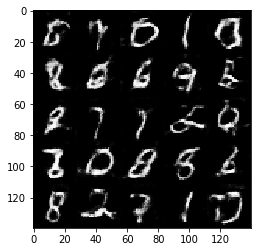

Epoch 1/2... Discriminator Loss: 1.4813... Generator Loss: 0.3841
Epoch 1/2... Discriminator Loss: 1.3858... Generator Loss: 0.4995
Epoch 1/2... Discriminator Loss: 1.8768... Generator Loss: 0.2629
Epoch 1/2... Discriminator Loss: 1.5076... Generator Loss: 0.4058
Epoch 1/2... Discriminator Loss: 1.5240... Generator Loss: 0.3786


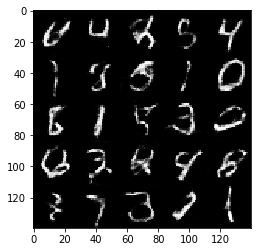

Epoch 1/2... Discriminator Loss: 1.1926... Generator Loss: 0.6129
Epoch 1/2... Discriminator Loss: 1.3767... Generator Loss: 0.5110
Epoch 1/2... Discriminator Loss: 1.4509... Generator Loss: 0.5475
Epoch 1/2... Discriminator Loss: 1.4695... Generator Loss: 0.3242
Epoch 1/2... Discriminator Loss: 1.3879... Generator Loss: 0.4717


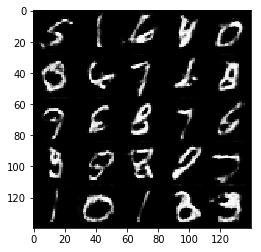

Epoch 1/2... Discriminator Loss: 1.0936... Generator Loss: 0.7572
Epoch 1/2... Discriminator Loss: 1.2165... Generator Loss: 0.6053
Epoch 1/2... Discriminator Loss: 1.4116... Generator Loss: 0.6324
Epoch 1/2... Discriminator Loss: 1.6064... Generator Loss: 0.4329
Epoch 1/2... Discriminator Loss: 1.3192... Generator Loss: 0.5351


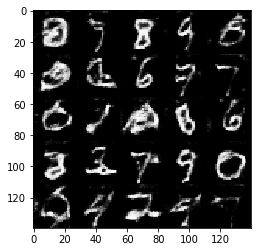

Epoch 1/2... Discriminator Loss: 1.2216... Generator Loss: 0.5689
Epoch 1/2... Discriminator Loss: 1.2705... Generator Loss: 0.4096
Epoch 1/2... Discriminator Loss: 1.4828... Generator Loss: 1.3753
Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 0.7320
Epoch 1/2... Discriminator Loss: 1.1777... Generator Loss: 0.5695


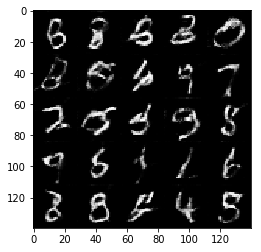

Epoch 1/2... Discriminator Loss: 1.0574... Generator Loss: 0.7218
Epoch 1/2... Discriminator Loss: 1.2363... Generator Loss: 0.8423
Epoch 1/2... Discriminator Loss: 1.9077... Generator Loss: 0.2258
Epoch 1/2... Discriminator Loss: 1.4897... Generator Loss: 0.5012
Epoch 1/2... Discriminator Loss: 0.9500... Generator Loss: 0.7219


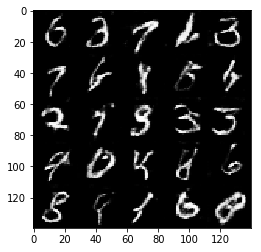

Epoch 1/2... Discriminator Loss: 1.1571... Generator Loss: 0.5604
Epoch 1/2... Discriminator Loss: 1.2997... Generator Loss: 0.5108
Epoch 1/2... Discriminator Loss: 1.8020... Generator Loss: 0.2784
Epoch 2/2... Discriminator Loss: 1.1535... Generator Loss: 0.6198
Epoch 2/2... Discriminator Loss: 0.9668... Generator Loss: 0.9901


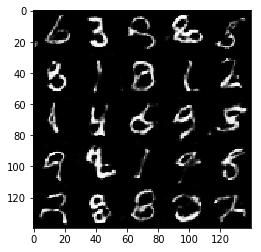

Epoch 2/2... Discriminator Loss: 1.2874... Generator Loss: 0.5573
Epoch 2/2... Discriminator Loss: 1.3774... Generator Loss: 0.4779
Epoch 2/2... Discriminator Loss: 1.5099... Generator Loss: 0.4055
Epoch 2/2... Discriminator Loss: 1.7882... Generator Loss: 0.2594
Epoch 2/2... Discriminator Loss: 1.1584... Generator Loss: 0.6645


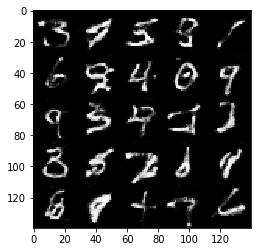

Epoch 2/2... Discriminator Loss: 1.2012... Generator Loss: 0.5963
Epoch 2/2... Discriminator Loss: 0.9843... Generator Loss: 0.6407
Epoch 2/2... Discriminator Loss: 1.2302... Generator Loss: 0.6333
Epoch 2/2... Discriminator Loss: 1.2659... Generator Loss: 0.4924
Epoch 2/2... Discriminator Loss: 1.2538... Generator Loss: 0.6164


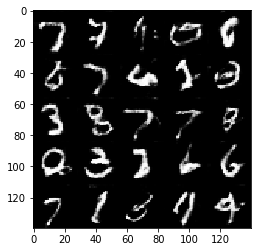

Epoch 2/2... Discriminator Loss: 1.1900... Generator Loss: 1.2322
Epoch 2/2... Discriminator Loss: 1.2529... Generator Loss: 0.5454
Epoch 2/2... Discriminator Loss: 1.2851... Generator Loss: 0.4442
Epoch 2/2... Discriminator Loss: 1.3438... Generator Loss: 0.3958
Epoch 2/2... Discriminator Loss: 1.7817... Generator Loss: 0.2142


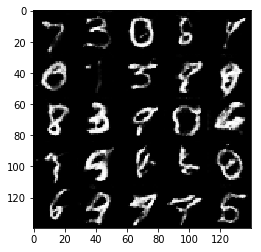

Epoch 2/2... Discriminator Loss: 1.2958... Generator Loss: 0.7382
Epoch 2/2... Discriminator Loss: 0.9985... Generator Loss: 0.7886
Epoch 2/2... Discriminator Loss: 1.2175... Generator Loss: 0.5883
Epoch 2/2... Discriminator Loss: 0.9549... Generator Loss: 0.6803
Epoch 2/2... Discriminator Loss: 1.1752... Generator Loss: 0.6040


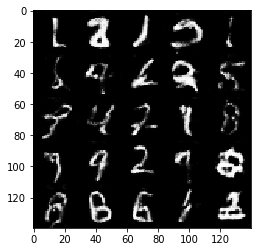

Epoch 2/2... Discriminator Loss: 1.4389... Generator Loss: 0.3478
Epoch 2/2... Discriminator Loss: 1.2937... Generator Loss: 0.4893
Epoch 2/2... Discriminator Loss: 1.0682... Generator Loss: 0.7433
Epoch 2/2... Discriminator Loss: 1.4007... Generator Loss: 0.4737
Epoch 2/2... Discriminator Loss: 1.5850... Generator Loss: 0.2998


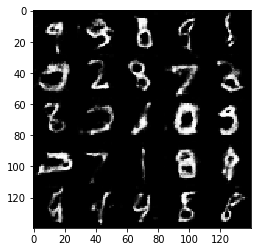

Epoch 2/2... Discriminator Loss: 0.8721... Generator Loss: 1.0359
Epoch 2/2... Discriminator Loss: 1.2138... Generator Loss: 0.5088
Epoch 2/2... Discriminator Loss: 0.9020... Generator Loss: 0.8389
Epoch 2/2... Discriminator Loss: 1.1069... Generator Loss: 0.8113
Epoch 2/2... Discriminator Loss: 1.1624... Generator Loss: 0.9686


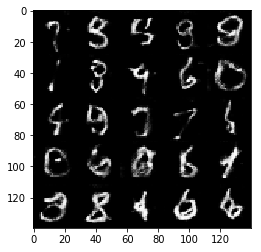

Epoch 2/2... Discriminator Loss: 1.0718... Generator Loss: 0.7680
Epoch 2/2... Discriminator Loss: 1.5242... Generator Loss: 0.3457
Epoch 2/2... Discriminator Loss: 1.5596... Generator Loss: 0.2952
Epoch 2/2... Discriminator Loss: 1.1812... Generator Loss: 1.5686
Epoch 2/2... Discriminator Loss: 1.0043... Generator Loss: 0.8378


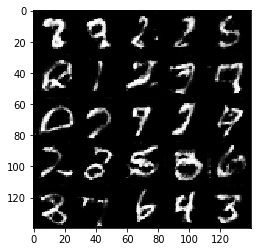

Epoch 2/2... Discriminator Loss: 0.7975... Generator Loss: 0.9160
Epoch 2/2... Discriminator Loss: 1.9434... Generator Loss: 0.2275
Epoch 2/2... Discriminator Loss: 1.3884... Generator Loss: 0.9026
Epoch 2/2... Discriminator Loss: 0.9655... Generator Loss: 1.0304
Epoch 2/2... Discriminator Loss: 1.0457... Generator Loss: 0.7383


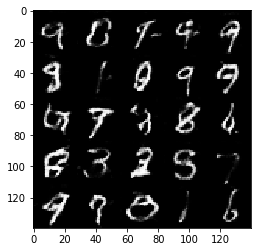

Epoch 2/2... Discriminator Loss: 1.8901... Generator Loss: 0.2000
Epoch 2/2... Discriminator Loss: 1.2030... Generator Loss: 0.5551
Epoch 2/2... Discriminator Loss: 1.5502... Generator Loss: 0.3639
Epoch 2/2... Discriminator Loss: 1.0953... Generator Loss: 0.6141
Epoch 2/2... Discriminator Loss: 1.4583... Generator Loss: 0.3663


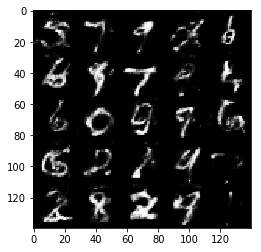

Epoch 2/2... Discriminator Loss: 1.2484... Generator Loss: 0.4681
Epoch 2/2... Discriminator Loss: 1.4974... Generator Loss: 0.3768
Epoch 2/2... Discriminator Loss: 1.9957... Generator Loss: 0.2068
Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 0.4491
Epoch 2/2... Discriminator Loss: 1.1882... Generator Loss: 0.5768


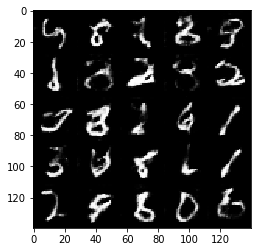

Epoch 2/2... Discriminator Loss: 1.5132... Generator Loss: 0.3970
Epoch 2/2... Discriminator Loss: 1.1418... Generator Loss: 0.6118
Epoch 2/2... Discriminator Loss: 2.1570... Generator Loss: 0.1745
Epoch 2/2... Discriminator Loss: 1.4994... Generator Loss: 0.4036
Epoch 2/2... Discriminator Loss: 1.2260... Generator Loss: 0.4948


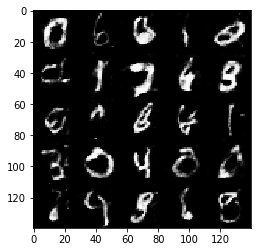

Epoch 2/2... Discriminator Loss: 1.2682... Generator Loss: 0.4265
Epoch 2/2... Discriminator Loss: 1.5316... Generator Loss: 0.3282
Epoch 2/2... Discriminator Loss: 1.0634... Generator Loss: 0.7126
Epoch 2/2... Discriminator Loss: 1.3959... Generator Loss: 0.4689
Epoch 2/2... Discriminator Loss: 0.9544... Generator Loss: 0.8410


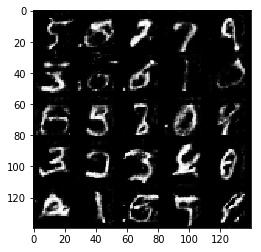

Epoch 2/2... Discriminator Loss: 1.3390... Generator Loss: 0.4979
Epoch 2/2... Discriminator Loss: 1.3694... Generator Loss: 0.5287
Epoch 2/2... Discriminator Loss: 1.1856... Generator Loss: 0.4675
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 0.4945
Epoch 2/2... Discriminator Loss: 1.5188... Generator Loss: 0.3580


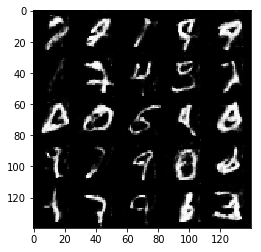

Epoch 2/2... Discriminator Loss: 1.9451... Generator Loss: 0.2263
Epoch 2/2... Discriminator Loss: 1.3818... Generator Loss: 0.4247
Epoch 2/2... Discriminator Loss: 1.4503... Generator Loss: 0.4602
Epoch 2/2... Discriminator Loss: 1.7924... Generator Loss: 0.2866
Epoch 2/2... Discriminator Loss: 1.2421... Generator Loss: 0.4815


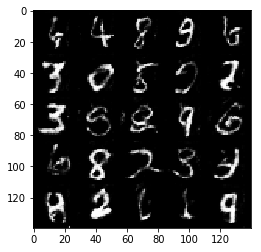

Epoch 2/2... Discriminator Loss: 1.3639... Generator Loss: 0.4487
Epoch 2/2... Discriminator Loss: 1.6402... Generator Loss: 1.5793
Epoch 2/2... Discriminator Loss: 1.3046... Generator Loss: 0.4430
Epoch 2/2... Discriminator Loss: 1.4261... Generator Loss: 0.4157
Epoch 2/2... Discriminator Loss: 1.1960... Generator Loss: 0.5322


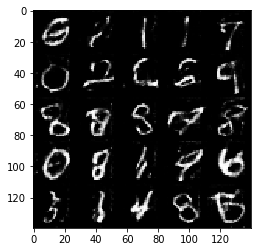

Epoch 2/2... Discriminator Loss: 1.2862... Generator Loss: 0.5811
Epoch 2/2... Discriminator Loss: 1.7941... Generator Loss: 0.2517
Epoch 2/2... Discriminator Loss: 1.3583... Generator Loss: 0.4044
Epoch 2/2... Discriminator Loss: 1.2726... Generator Loss: 0.5024
Epoch 2/2... Discriminator Loss: 1.2277... Generator Loss: 0.7054


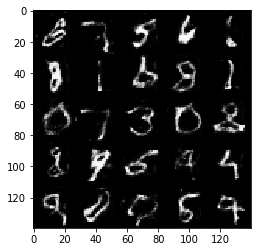

Epoch 2/2... Discriminator Loss: 1.2892... Generator Loss: 0.4173
Epoch 2/2... Discriminator Loss: 1.1723... Generator Loss: 0.5612
Epoch 2/2... Discriminator Loss: 0.9527... Generator Loss: 0.7514
Epoch 2/2... Discriminator Loss: 1.1660... Generator Loss: 0.5441
Epoch 2/2... Discriminator Loss: 1.1518... Generator Loss: 0.6161


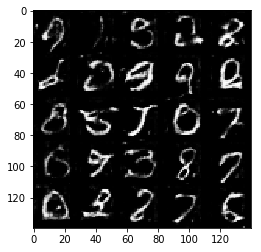

Epoch 2/2... Discriminator Loss: 1.0674... Generator Loss: 0.8704
Epoch 2/2... Discriminator Loss: 2.1358... Generator Loss: 0.1907
Epoch 2/2... Discriminator Loss: 1.4717... Generator Loss: 0.4675
Epoch 2/2... Discriminator Loss: 1.3037... Generator Loss: 0.4416
Epoch 2/2... Discriminator Loss: 1.2986... Generator Loss: 0.5772


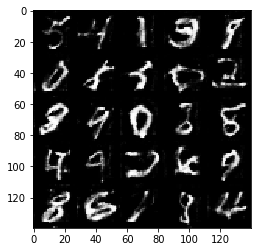

Epoch 2/2... Discriminator Loss: 1.5714... Generator Loss: 0.4009
Epoch 2/2... Discriminator Loss: 2.3835... Generator Loss: 0.1484


In [46]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 2.4282... Generator Loss: 0.4584
Epoch 1/1... Discriminator Loss: 2.6073... Generator Loss: 0.2871
Epoch 1/1... Discriminator Loss: 2.3648... Generator Loss: 0.1582
Epoch 1/1... Discriminator Loss: 2.2705... Generator Loss: 0.3122


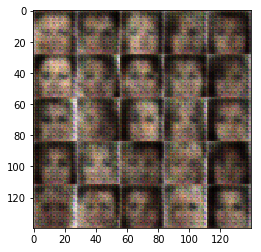

Epoch 1/1... Discriminator Loss: 1.5524... Generator Loss: 0.4139
Epoch 1/1... Discriminator Loss: 1.9665... Generator Loss: 0.3139
Epoch 1/1... Discriminator Loss: 1.9996... Generator Loss: 0.2857
Epoch 1/1... Discriminator Loss: 2.0621... Generator Loss: 0.3386
Epoch 1/1... Discriminator Loss: 1.9303... Generator Loss: 0.4351


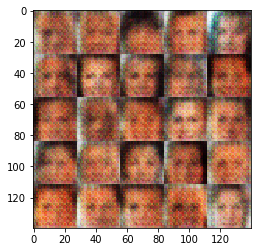

Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.5260
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 2.5041... Generator Loss: 0.1870
Epoch 1/1... Discriminator Loss: 1.5567... Generator Loss: 0.4720
Epoch 1/1... Discriminator Loss: 1.8573... Generator Loss: 0.4545


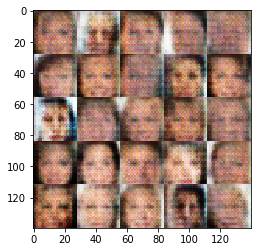

Epoch 1/1... Discriminator Loss: 1.7572... Generator Loss: 0.4965
Epoch 1/1... Discriminator Loss: 1.6360... Generator Loss: 0.3920
Epoch 1/1... Discriminator Loss: 1.9618... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.5379... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 0.5575


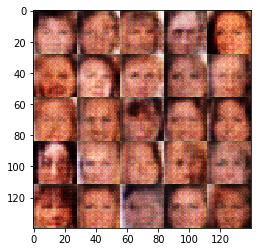

Epoch 1/1... Discriminator Loss: 1.6076... Generator Loss: 0.4743
Epoch 1/1... Discriminator Loss: 1.6121... Generator Loss: 0.4595
Epoch 1/1... Discriminator Loss: 1.5908... Generator Loss: 0.4771
Epoch 1/1... Discriminator Loss: 1.5660... Generator Loss: 0.5433
Epoch 1/1... Discriminator Loss: 1.5098... Generator Loss: 0.5808


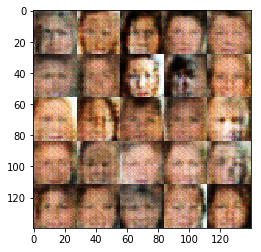

Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 0.4649
Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.5720
Epoch 1/1... Discriminator Loss: 1.5860... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 1.5165... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.5717... Generator Loss: 0.5989


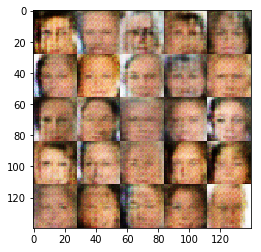

Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.6161
Epoch 1/1... Discriminator Loss: 1.6817... Generator Loss: 0.4931
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.5305... Generator Loss: 0.5318
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.5418


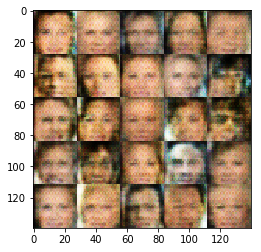

Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.5024
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 1.5396... Generator Loss: 0.4840
Epoch 1/1... Discriminator Loss: 1.6323... Generator Loss: 0.5478
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.5904


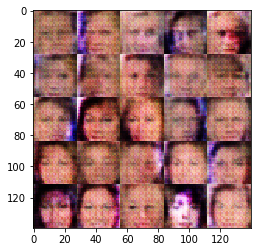

Epoch 1/1... Discriminator Loss: 1.7540... Generator Loss: 0.4978
Epoch 1/1... Discriminator Loss: 1.6363... Generator Loss: 0.5093
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.5488
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.5127
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.6038


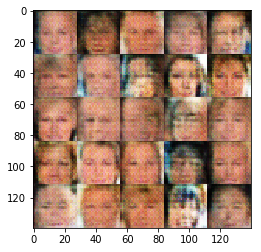

Epoch 1/1... Discriminator Loss: 1.5923... Generator Loss: 0.4926
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.5208
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.5509
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.5521


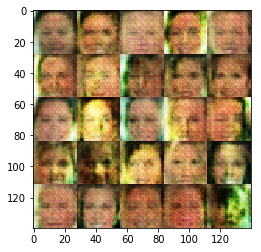

Epoch 1/1... Discriminator Loss: 1.5672... Generator Loss: 0.5406
Epoch 1/1... Discriminator Loss: 1.5337... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 0.5190
Epoch 1/1... Discriminator Loss: 1.5737... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.6233


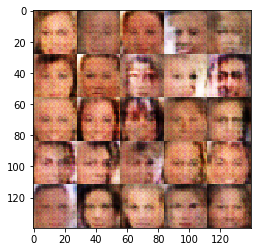

Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 1.5876... Generator Loss: 0.5270
Epoch 1/1... Discriminator Loss: 1.5756... Generator Loss: 0.4517
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.5144
Epoch 1/1... Discriminator Loss: 1.5774... Generator Loss: 0.5239


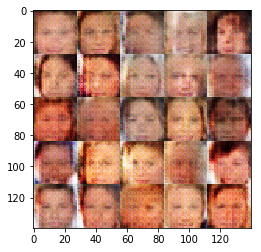

Epoch 1/1... Discriminator Loss: 1.5680... Generator Loss: 0.4541
Epoch 1/1... Discriminator Loss: 1.6947... Generator Loss: 0.4692
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.6768... Generator Loss: 0.4454
Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.5348


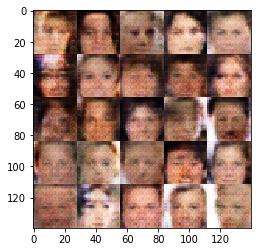

Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 0.4720
Epoch 1/1... Discriminator Loss: 1.7380... Generator Loss: 0.4550
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.5206
Epoch 1/1... Discriminator Loss: 1.5337... Generator Loss: 0.5020
Epoch 1/1... Discriminator Loss: 1.5755... Generator Loss: 0.4811


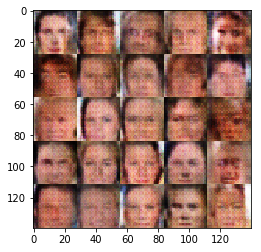

Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.6710... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 1.5956... Generator Loss: 0.4845


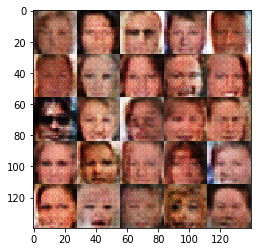

Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.5912
Epoch 1/1... Discriminator Loss: 1.6156... Generator Loss: 0.4709
Epoch 1/1... Discriminator Loss: 1.6116... Generator Loss: 0.5250
Epoch 1/1... Discriminator Loss: 1.5909... Generator Loss: 0.5154
Epoch 1/1... Discriminator Loss: 1.6126... Generator Loss: 0.4041


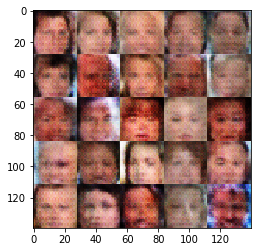

Epoch 1/1... Discriminator Loss: 1.5451... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.5772... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.6449... Generator Loss: 0.3786
Epoch 1/1... Discriminator Loss: 1.6221... Generator Loss: 0.5444
Epoch 1/1... Discriminator Loss: 1.6290... Generator Loss: 0.5240


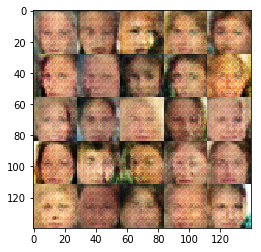

Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.4956
Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.5694
Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.6593... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.5480


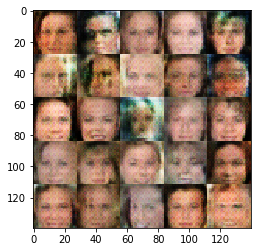

Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 1.5559... Generator Loss: 0.4894
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.5231... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.5893... Generator Loss: 0.5626


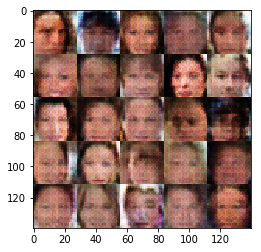

Epoch 1/1... Discriminator Loss: 1.6764... Generator Loss: 0.4683
Epoch 1/1... Discriminator Loss: 1.6703... Generator Loss: 0.4453
Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 1.5721... Generator Loss: 0.5205
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.5704


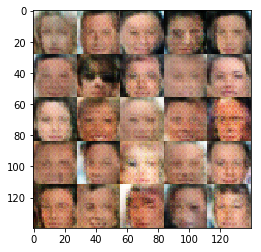

Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 0.5358
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.5584
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.5495
Epoch 1/1... Discriminator Loss: 1.6422... Generator Loss: 0.3991


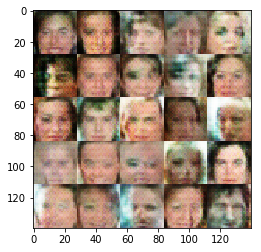

Epoch 1/1... Discriminator Loss: 1.5435... Generator Loss: 0.5006
Epoch 1/1... Discriminator Loss: 1.6013... Generator Loss: 0.4687
Epoch 1/1... Discriminator Loss: 1.6428... Generator Loss: 0.5000
Epoch 1/1... Discriminator Loss: 1.7303... Generator Loss: 0.4610
Epoch 1/1... Discriminator Loss: 1.6654... Generator Loss: 0.4634


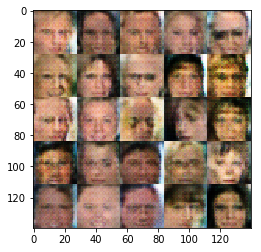

Epoch 1/1... Discriminator Loss: 1.5685... Generator Loss: 0.5031
Epoch 1/1... Discriminator Loss: 1.5306... Generator Loss: 0.5402
Epoch 1/1... Discriminator Loss: 1.6506... Generator Loss: 0.4445
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.5786
Epoch 1/1... Discriminator Loss: 1.5032... Generator Loss: 0.4965


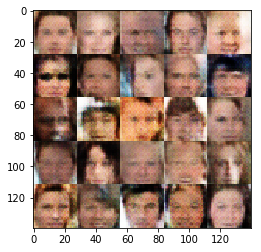

Epoch 1/1... Discriminator Loss: 1.6021... Generator Loss: 0.4631
Epoch 1/1... Discriminator Loss: 1.5809... Generator Loss: 0.4761
Epoch 1/1... Discriminator Loss: 1.7190... Generator Loss: 0.4519
Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.5197
Epoch 1/1... Discriminator Loss: 1.5663... Generator Loss: 0.4930


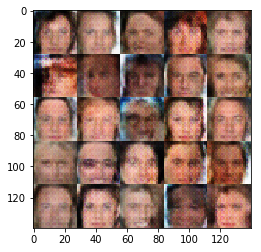

Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.4871
Epoch 1/1... Discriminator Loss: 1.6010... Generator Loss: 0.4230
Epoch 1/1... Discriminator Loss: 1.6907... Generator Loss: 0.4211
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.5511
Epoch 1/1... Discriminator Loss: 1.6411... Generator Loss: 0.4709


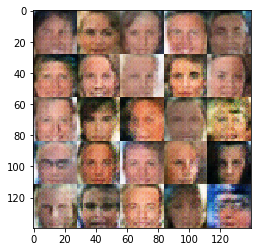

Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 1.6897... Generator Loss: 0.4692
Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 0.4982
Epoch 1/1... Discriminator Loss: 1.6171... Generator Loss: 0.4775
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.5328


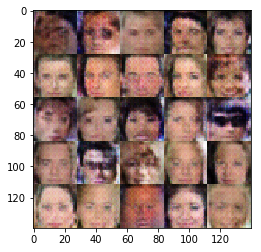

Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 1.5265... Generator Loss: 0.5224
Epoch 1/1... Discriminator Loss: 1.5900... Generator Loss: 0.4540
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.5512


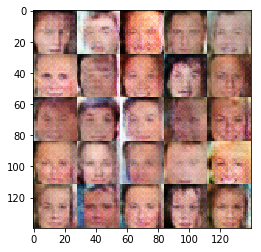

Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 0.5254
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 1.6062... Generator Loss: 0.4708


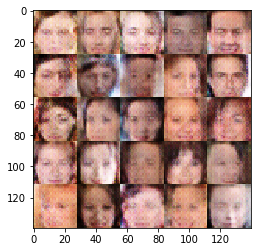

Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.5400
Epoch 1/1... Discriminator Loss: 1.5540... Generator Loss: 0.4962
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.6160... Generator Loss: 0.4978


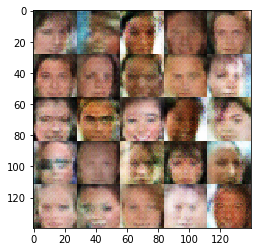

Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.5150
Epoch 1/1... Discriminator Loss: 1.6236... Generator Loss: 0.4174
Epoch 1/1... Discriminator Loss: 1.6506... Generator Loss: 0.5237
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.6545... Generator Loss: 0.4578


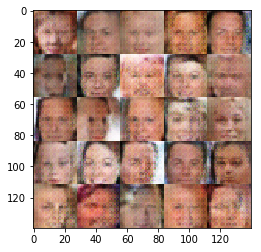

Epoch 1/1... Discriminator Loss: 1.6515... Generator Loss: 0.4456
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 1.5396... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.6612... Generator Loss: 0.4731


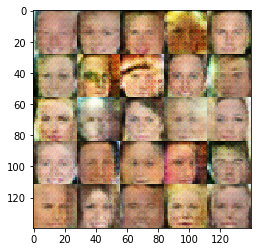

Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.4942
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.5721... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.6389... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 1.6101... Generator Loss: 0.4843


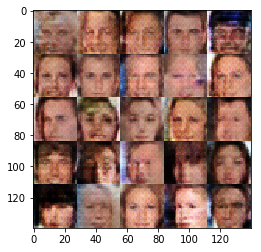

Epoch 1/1... Discriminator Loss: 1.5433... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.5766... Generator Loss: 0.5023
Epoch 1/1... Discriminator Loss: 1.5553... Generator Loss: 0.4915
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.5305


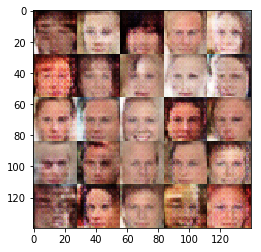

Epoch 1/1... Discriminator Loss: 1.5983... Generator Loss: 0.5458
Epoch 1/1... Discriminator Loss: 1.7208... Generator Loss: 0.3906
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.5436


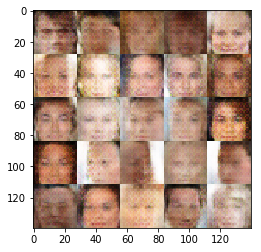

Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.6037... Generator Loss: 0.5126
Epoch 1/1... Discriminator Loss: 1.6904... Generator Loss: 0.4052
Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 0.5302


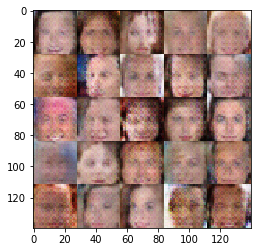

Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.5760
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.4813
Epoch 1/1... Discriminator Loss: 1.5977... Generator Loss: 0.5047
Epoch 1/1... Discriminator Loss: 1.6243... Generator Loss: 0.4701
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.5341


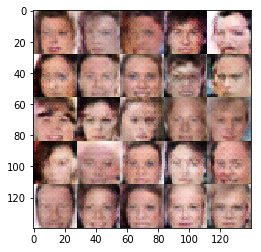

Epoch 1/1... Discriminator Loss: 1.5636... Generator Loss: 0.5251
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 1.5375... Generator Loss: 0.4970
Epoch 1/1... Discriminator Loss: 1.5571... Generator Loss: 0.4729
Epoch 1/1... Discriminator Loss: 1.5968... Generator Loss: 0.5040


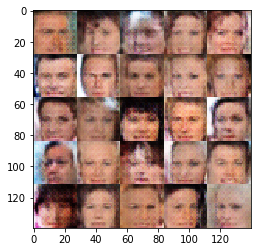

Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.7051... Generator Loss: 0.4183
Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 0.4889
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 1.6173... Generator Loss: 0.4762


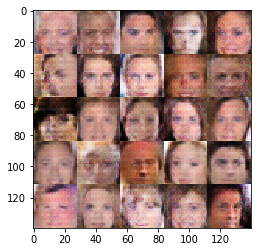

Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.5113
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 1.5219... Generator Loss: 0.4852
Epoch 1/1... Discriminator Loss: 1.7233... Generator Loss: 0.3640
Epoch 1/1... Discriminator Loss: 1.5247... Generator Loss: 0.4889


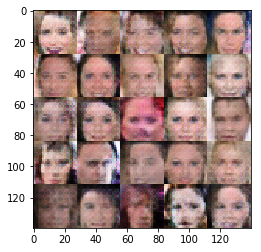

Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 1.5997... Generator Loss: 0.5362
Epoch 1/1... Discriminator Loss: 1.5777... Generator Loss: 0.4904
Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 0.4975
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.5158


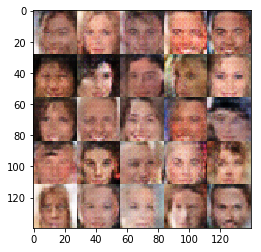

Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.5189
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.7464... Generator Loss: 0.3809


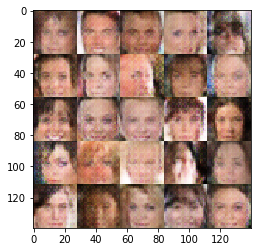

Epoch 1/1... Discriminator Loss: 1.5431... Generator Loss: 0.4827
Epoch 1/1... Discriminator Loss: 1.5433... Generator Loss: 0.4803
Epoch 1/1... Discriminator Loss: 1.5945... Generator Loss: 0.4723
Epoch 1/1... Discriminator Loss: 1.5691... Generator Loss: 0.4886
Epoch 1/1... Discriminator Loss: 1.5868... Generator Loss: 0.4532


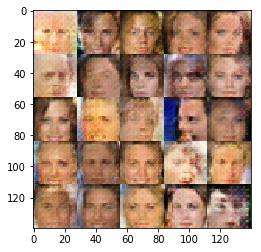

Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.5541
Epoch 1/1... Discriminator Loss: 1.5868... Generator Loss: 0.4700
Epoch 1/1... Discriminator Loss: 1.5820... Generator Loss: 0.4332
Epoch 1/1... Discriminator Loss: 1.6939... Generator Loss: 0.3669


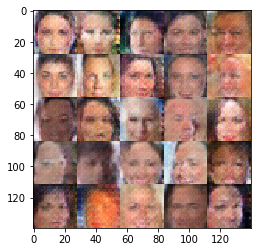

Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.5644
Epoch 1/1... Discriminator Loss: 1.6594... Generator Loss: 0.3902
Epoch 1/1... Discriminator Loss: 1.6339... Generator Loss: 0.3992
Epoch 1/1... Discriminator Loss: 1.5817... Generator Loss: 0.4794
Epoch 1/1... Discriminator Loss: 1.7666... Generator Loss: 0.4293


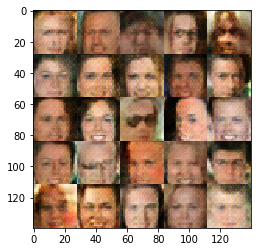

Epoch 1/1... Discriminator Loss: 1.5671... Generator Loss: 0.4745
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.5210
Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 0.5139
Epoch 1/1... Discriminator Loss: 1.6150... Generator Loss: 0.3834


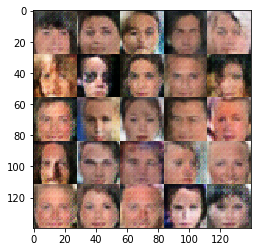

Epoch 1/1... Discriminator Loss: 1.6029... Generator Loss: 0.4658
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.5248
Epoch 1/1... Discriminator Loss: 1.8557... Generator Loss: 0.3671
Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.7365


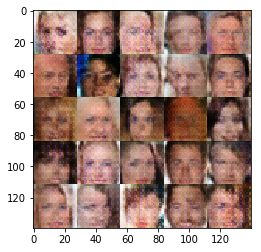

Epoch 1/1... Discriminator Loss: 1.6936... Generator Loss: 0.4251
Epoch 1/1... Discriminator Loss: 1.5633... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.5177
Epoch 1/1... Discriminator Loss: 1.7678... Generator Loss: 0.3773
Epoch 1/1... Discriminator Loss: 1.6146... Generator Loss: 0.4298


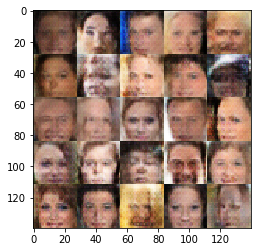

Epoch 1/1... Discriminator Loss: 1.5488... Generator Loss: 0.5250
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.4610
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.5023
Epoch 1/1... Discriminator Loss: 1.5320... Generator Loss: 0.4744


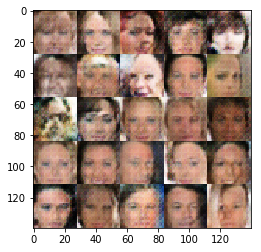

Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.6101... Generator Loss: 0.4911
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.4712
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.5602


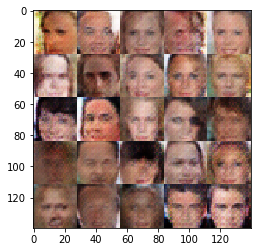

Epoch 1/1... Discriminator Loss: 1.6248... Generator Loss: 0.4433
Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 0.5060
Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 0.4483
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 0.4319
Epoch 1/1... Discriminator Loss: 1.5109... Generator Loss: 0.4952


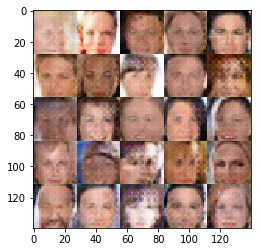

Epoch 1/1... Discriminator Loss: 1.5611... Generator Loss: 0.4636
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 1.5749... Generator Loss: 0.4580
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.5285
Epoch 1/1... Discriminator Loss: 1.5645... Generator Loss: 0.5199


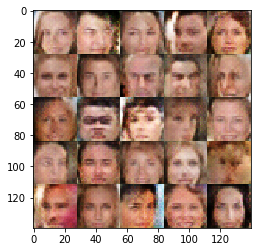

Epoch 1/1... Discriminator Loss: 1.7073... Generator Loss: 0.3887
Epoch 1/1... Discriminator Loss: 1.5916... Generator Loss: 0.4370
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.5368
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 0.5223


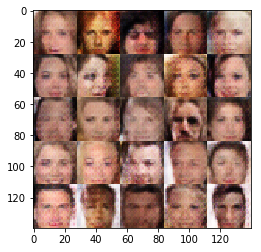

Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.5659
Epoch 1/1... Discriminator Loss: 1.5851... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 1.6605... Generator Loss: 0.3963
Epoch 1/1... Discriminator Loss: 1.6113... Generator Loss: 0.4138
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.5616


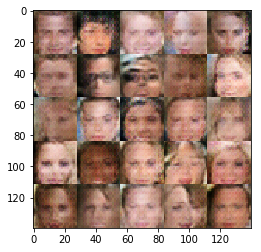

Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 1.5641... Generator Loss: 0.5018
Epoch 1/1... Discriminator Loss: 1.6711... Generator Loss: 0.4256
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.5149
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.5541


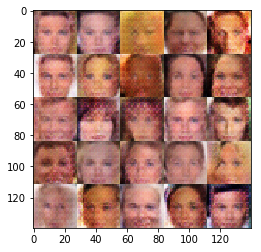

Epoch 1/1... Discriminator Loss: 1.7455... Generator Loss: 0.4446
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 1.5859... Generator Loss: 0.4640
Epoch 1/1... Discriminator Loss: 1.5740... Generator Loss: 0.4886
Epoch 1/1... Discriminator Loss: 1.8800... Generator Loss: 0.3459


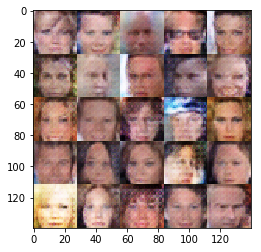

Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.5346
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.4927
Epoch 1/1... Discriminator Loss: 1.6716... Generator Loss: 0.4448


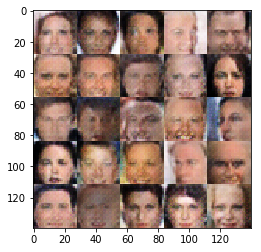

Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.4691
Epoch 1/1... Discriminator Loss: 1.5862... Generator Loss: 0.5094
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 1.5722... Generator Loss: 0.5081
Epoch 1/1... Discriminator Loss: 1.5312... Generator Loss: 0.4642


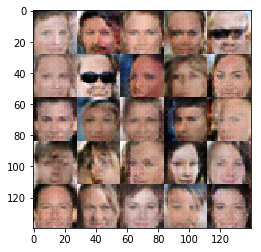

Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.4352
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.4802
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.4514
Epoch 1/1... Discriminator Loss: 1.8707... Generator Loss: 0.3248


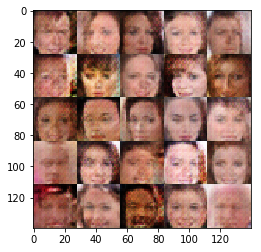

Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.4996
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.5422
Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.5005
Epoch 1/1... Discriminator Loss: 1.5224... Generator Loss: 0.5066


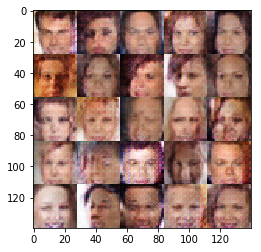

Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.5786... Generator Loss: 0.5161
Epoch 1/1... Discriminator Loss: 1.7067... Generator Loss: 0.4000
Epoch 1/1... Discriminator Loss: 1.6793... Generator Loss: 0.4375
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.4741


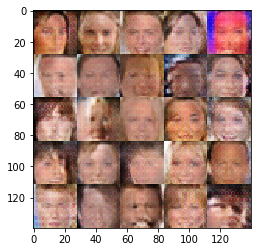

Epoch 1/1... Discriminator Loss: 1.6250... Generator Loss: 0.5357
Epoch 1/1... Discriminator Loss: 1.6421... Generator Loss: 0.3614
Epoch 1/1... Discriminator Loss: 1.5927... Generator Loss: 0.4646
Epoch 1/1... Discriminator Loss: 1.6638... Generator Loss: 0.4635
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.4679


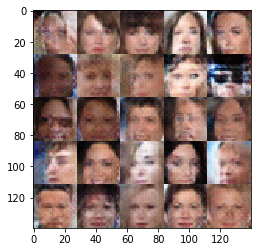

Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.5457
Epoch 1/1... Discriminator Loss: 1.7439... Generator Loss: 0.3604
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 1.5773... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.5147


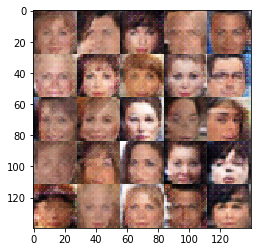

Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.5249
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.4801
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.5271
Epoch 1/1... Discriminator Loss: 1.6015... Generator Loss: 0.4232
Epoch 1/1... Discriminator Loss: 1.5503... Generator Loss: 0.4771


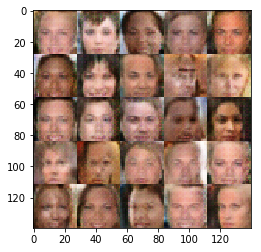

Epoch 1/1... Discriminator Loss: 1.5695... Generator Loss: 0.4689


In [48]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.